In [1]:
import numpy as np
import pydicom
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as ptchs

import scipy.ndimage
from skimage import draw
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from skimage import filters
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from tensorflow.keras import Model, Sequential 
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Conv2D, MaxPool2D, AveragePooling2D, GlobalAveragePooling1D, GlobalAveragePooling2D, MaxPooling2D , Conv3D, Layer, MaxPooling2D, Dropout, Flatten, Dense, GRU, ConvLSTM2D, Input, BatchNormalization, TimeDistributed, MaxPooling3D, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from random import shuffle
from tensorflow.keras.regularizers import l2
from keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.constraints import max_norm
import segmentation_models as sm

# import seaborn as sns
# import IPython
# from six.moves import urllib
print(tf.__version__)
print(keras.__version__)
import re
import math
import random
# import bisect
np.random.seed(1234)
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import warnings
warnings.filterwarnings(action='once')

MAX_SEQ_LENGTH = 200
NUM_FEATURES = 1024
IMG_SIZE = 512
BATCH_SIZE = 4
EPOCHS = 2
image_path = "/home/data/rsna-str-pulmonary-embolism-detection/train"
NUM_SCANS = 8
NUM_CHANNELS = 1
INPUT_DIM = 256

Segmentation Models: using `keras` framework.
2.7.0
2.7.0
Num GPUs Available:  0


2022-08-30 13:55:39.807064: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-30 13:55:39.807128: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: mim-1-3
2022-08-30 13:55:39.807145: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: mim-1-3
2022-08-30 13:55:39.807325: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 495.29.5
2022-08-30 13:55:39.807376: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 495.29.5
2022-08-30 13:55:39.807392: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 495.29.5


In [2]:
train_slides = pd.read_csv('singlescans/train_slides.csv')
test_slides = pd.read_csv('singlescans/test_slides.csv')
val_slides = pd.read_csv('singlescans/val_slides.csv')

train_slides = train_slides.sample(frac=1).reset_index(drop=True)
test_slides = test_slides.sample(frac=1).reset_index(drop=True)
val_slides = val_slides.sample(frac=1).reset_index(drop=True)

print(f"Total videos for training: {len(train_slides)}")
print(f"Total videos for validation: {len(val_slides)}")

class DataGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, list_IDs, labels, image_path, mask_path=None,
                 to_fit=True, batch_size=32, dim=(370, 370),
                 n_channels=1, n_classes=2, shuffle=True,verbose=False):
        """Initialization
        :param list_IDs: list of all 'label' ids to use in the generator
        :param labels: list of image labels (file names)
        :param image_path: path to images location
        :param mask_path: path to masks location
        :param to_fit: True to return X and y, False to return X only
        :param batch_size: batch size at each iteration
        :param dim: tuple indicating image dimension
        :param n_channels: number of image channels
        :param n_classes: number of output masks
        :param shuffle: True to shuffle label indexes after every epoch
        """
        self.list_IDs = list_IDs
        self.labels = labels
#         self.image_path = image_path
        self.mask_path = mask_path
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.path_dicom = image_path
        self.verbose = verbose
        warnings.filterwarnings(action='ignore')
        
    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))


    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        
        indexes = self.list_IDs[index * self.batch_size:((index+1) * self.batch_size)]
        X = np.zeros([self.batch_size,IMG_SIZE,IMG_SIZE,NUM_CHANNELS])
        y = np.zeros([self.batch_size, 1])
        for i in range(0,self.batch_size):
            X[i], y[i] = self._load_dicom(indexes[i])
        if self.to_fit:
            return (X, y)
        else:
            return (X)
        
    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
#         self.list_IDs = np.arange(len(self.list_IDs))
        if self.shuffle == True:
#             print('shuffling', self.list_IDs[:10])
            np.random.shuffle(self.list_IDs)
#             print('shuffled', self.list_IDs[:10])


    def _load_dicom(self, index):
#         """Load all dicom images in study
#         :param study_id: study id
#         :return: loaded ct scan in hounsfield units
#         """
#         try:
            slice = self.labels.iloc[index] 
            
            print(slice.StudyInstanceUID, slice.SOPInstanceUID)
            interept = slope = 0
            data = pydicom.dcmread(os.path.join(image_path, slice.StudyInstanceUID, slice.SeriesInstanceUID , slice.SOPInstanceUID + '.dcm'))
                
            intercept = int(float(data.get_item([0x0028, 0x1052]).value)) 
            slope = int(float(data.get_item([0x0028, 0x1053]).value))                
            img = np.asarray(data.pixel_array  * slope + intercept)
#             frame = np.zeros([512,512,3])
#             frame[:,:,0] = (img.clip(-1000, 0)+500)/500
#             frame[:,:,1] = (img.clip(-50,500)-225)/275
#             frame[:,:,2] = (img.clip(-160, 240)-40)/200
#             print(np.shape(frame))
            frame = img
#             frame = (img.clip(-300, 500)-100)/400
            frame = frame.reshape((512,512,1))


#             im = Image.fromarray(img).convert('RGB').resize((IMG_SIZE,IMG_SIZE)) 
            frame = frame[None, ...]
#             temp_frame_features = feature_extractor.predict(frame)
#             temp_frame_features = temp_frame_features/70
#             temp_frame_features = temp_frame_features[None,...]
            y = np.array([int(slice.pe_present_on_image)])
            y = y[None, ...]
            
            if self.verbose:
                fig, ax = plt.subplots(1, 4, figsize=[24, 24])
                ax[0].imshow(frame[0,:,:,0]/2 + 0.5)
                ax[0].axis('off')
                ax[1].imshow(frame[0,:,:,1]/2 +0.5)
                ax[1].axis('off')
                ax[2].imshow(frame[0,:,:,2]/2 + 0.5)
                ax[2].axis('off')
                ax[3].imshow(frame[0,:,:,:]/2 +0.5)
                ax[3].axis('off')
                print(y)

                plt.show()
                print('Image min and max', img.min(), img.max())
#                 print('Feature frames min and max', temp_frame_features.min(), temp_frame_features.max())

            return frame, y
    
training_generator = DataGenerator(np.arange(0, len(train_slides)), train_slides, image_path, batch_size=BATCH_SIZE, verbose=False)
validation_generator = DataGenerator(np.arange(0, len(val_slides)), val_slides, image_path, batch_size=BATCH_SIZE, verbose=False)
test_generator = DataGenerator(np.arange(0, len(test_slides)), test_slides, image_path, batch_size=BATCH_SIZE, verbose=False)

Total videos for training: 141706
Total videos for validation: 18496


In [2921]:
def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
#     img = filters.gaussian(img, sigma=1)
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
 
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

#     row, col = draw.circle_perimeter(255,255, 256)
#     thresh_img[row,col] = 0
#     row, col = draw.circle_perimeter(255,255, 255)
#     thresh_img[row,col] = 0   
#     row, col = draw.circle_perimeter(255,255, 254)
#     thresh_img[row,col] = 0   
#     row, col = draw.circle_perimeter(255,255, 253)
#     thresh_img[row,col] = 0   
    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([4,4]))
    dilation = morphology.dilation(eroded,np.ones([12,12]))
    
    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    i = 0
    for prop in regions:
        B = prop.bbox
        print(B)
#         B[1] != 362 and B[0] < 300 and  B[1] < 300 and B[2] >175 and
# 
#         if B[0] == 349 or B[0] == 355 or 
        if (B[0] <300 and B[2]-B[0]<(row_size*0.9) and B[3]-B[1]<(col_size*0.9) and B[1] > col_size*0.001 and B[3] < col_size*0.95 and B[0] > row_size*0.01 and B[2] < row_size * 0.95):
            good_labels.append(prop.label)
        i = i+1
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0
    
    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([1,1])) # one last dilation

# #   ###  Bottom left lung
#     xx = 155
#     yy = 340
#     w = 60
#     h = 60
#     rr, cc = draw.ellipse_perimeter(yy,xx,w,h,1.57)
#     mask[rr,cc]=1
     
# # # # # # # # # # #     ## Bottom Right Lung
    xx = 512-180
    yy = 290
    w = 60
    h = 60
    rr, cc = draw.ellipse_perimeter(yy,xx,w,h,1.57)
    mask[rr,cc]=1

#    ###Top Left
#     xx = 160
#     yy = 150
#     w = 50
#     h = 50
#     rr, cc = draw.ellipse_perimeter(yy,xx,w,h,1.57)
#     mask[rr,cc]=1

# # # #   ## Top Right
#     xx = 512-170
#     yy = 150
#     w = 60
#     h = 60
#     rr, cc = draw.ellipse_perimeter(yy,xx,w,h,1.57)
#     mask[rr,cc]=1

  ### Whole Left
#     xx = 50
#     yy = 260
#     w = 90
#     h = 150
#     rr, cc = draw.ellipse_perimeter(yy,xx,w,h,1.57)
#     mask[rr,cc]=1

# # # # #   ## Whole Right
#     xx = 512-150
#     yy = 245
#     w = 90
#     h = 170
#     rr, cc = draw.ellipse_perimeter(yy,xx,w,h,1.57)
#     mask[rr,cc]=1

  # Erase
#     start = (0,0)
#     end = (511,30)
#     rr, cc = draw.rectangle(start=start,end=end)
#     mask[rr,cc]= 0
    
#     start = (300,400)
#     end = (511,511)
#     rr, cc = draw.rectangle(start=start,end=end)
#     mask[rr,cc]= 0
    
    
#     start = (400,0)
#     end = (511,511)
#     rr, cc = draw.rectangle(start=start,end=end)
#     mask[rr,cc]= 0
 
    
    
    mask = morphology.convex_hull_image(mask)

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask

In [4]:
train_slides = train_slides.sample(frac= 1).reset_index()

In [5]:
# train_scans = pd.DataFrame(columns=['Study','SOP','Original','Mask'])

In [2917]:
i = i+1

2c55ab4208e7 dba51e1a6d59
(0, 0, 512, 512)
(189, 131, 340, 266)
(194, 270, 327, 398)
(258, 269, 271, 286)


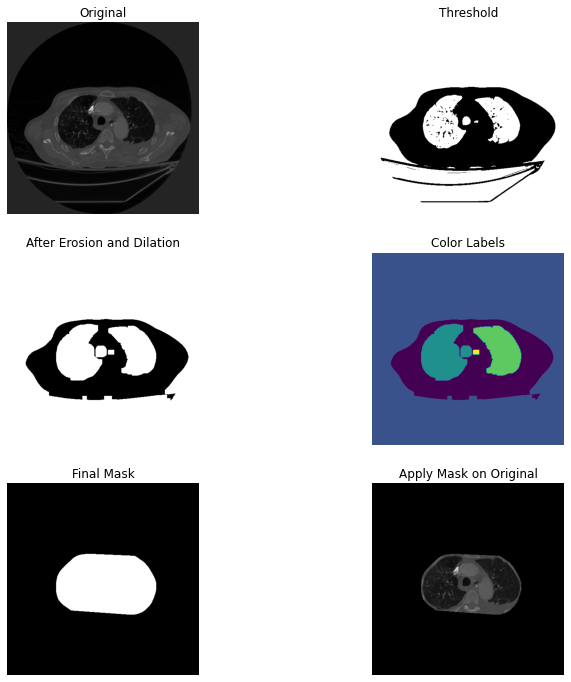

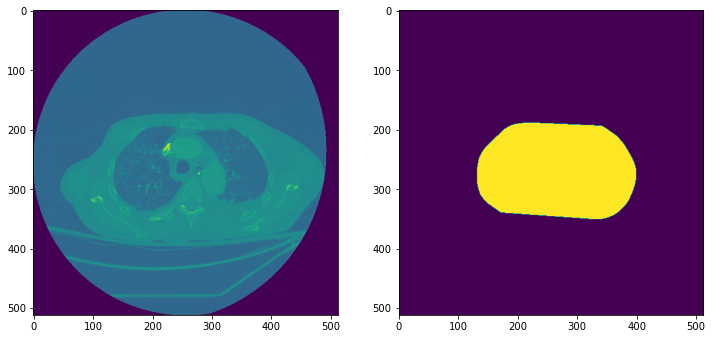

In [2922]:
img = training_generator._load_dicom(i)[0][0].squeeze()
# rr, cc = draw.ellipse_perimeter(50,50,10,15,1.57)
masked = make_lungmask(img, display=True)
fig, ax = plt.subplots(1, 2, figsize=[12, 24])
ax[0].imshow(img)
# ax[0].axis('off')
ax[1].imshow(masked)
# ax[1].axis('off')

plt.show()


In [2923]:
train_scans = train_scans.append( {'Study':train_slides.iloc[i].StudyInstanceUID,'SOP':train_slides.iloc[i].SOPInstanceUID,'Original':img,'Mask':masked.astype(int)}, ignore_index = True)
len(train_scans)

500

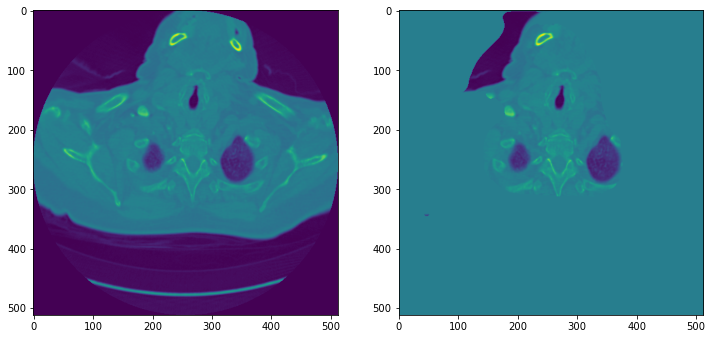

In [2693]:
fig, ax = plt.subplots(1, 2, figsize=[12, 24])
masked = np.round(model.predict(img[None,...])[0,:,:,0])
ax[0].imshow(img)
ax[1].imshow(masked*img)

In [2915]:
masked = np.zeros([512,512])

In [2262]:
len(train_scans)

402

In [2261]:
train_scans = train_scans.drop([402])

In [5]:
origials = np.asarray(np.load('segment_originals.npy', allow_pickle=True))
masks = np.asarray(np.load('segment_masks.npy', allow_pickle=True))

In [6]:
origials = origials[None,...]
masks = masks[None,...]

In [7]:
origials = origials.squeeze()
masks = masks.squeeze()

In [3]:


class DataGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, list_IDs, originals, masks,
                 to_fit=True, batch_size=32,
                 shuffle=True,verbose=False):
        """Initialization
        :param list_IDs: list of all 'label' ids to use in the generator
        :param labels: list of image labels (file names)
        :param image_path: path to images location
        :param mask_path: path to masks location
        :param to_fit: True to return X and y, False to return X only
        :param batch_size: batch size at each iteration
        :param dim: tuple indicating image dimension
        :param n_channels: number of image channels
        :param n_classes: number of output masks
        :param shuffle: True to shuffle label indexes after every epoch
        """
        self.list_IDs = list_IDs
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.originals = originals
        self.masks = masks
        warnings.filterwarnings(action='ignore')
        
        
    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))


    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        
        indexes = self.list_IDs[index * self.batch_size:((index+1) * self.batch_size)]
        X = np.zeros([self.batch_size, 512,512])
        y = np.zeros([self.batch_size, 512,512])
        
        for i in range(0,self.batch_size):
            X[i] = self.originals[indexes[i]]
            y[i] = self.masks[indexes[i]]
        
        X = np.reshape(X, (self.batch_size,512,512,1))
        y = np.reshape(y, (self.batch_size,512,512,1))
        
        if self.to_fit:
            return (X, y)
        else:
            return (X)
        
    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
#         self.list_IDs = np.arange(len(self.list_IDs))
        if self.shuffle == True:
#             print('shuffling', self.list_IDs[:10])
            np.random.shuffle(self.list_IDs)
#             print('shuffled', self.list_IDs[:10])


    
# training_generator = DataGenerator(np.arange(0, len(x_train[0])).astype(int), x_train[0], y_train[0], batch_size=BATCH_SIZE, verbose=False)
# validation_generator = DataGenerator(np.arange(0, len(x_val[0])).astype(int), x_val[0], y_val[0], batch_size=BATCH_SIZE, verbose=False)
# test_generator = DataGenerator(np.arange(0, len(test_slides)), test_slides, image_path, batch_size=BATCH_SIZE, verbose=False)

In [ ]:
train_seg.

In [2924]:
originals = train_scans['Original']
masks = train_scans['Mask']

In [4]:
import segmentation_models as sm

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

x_train = preprocess_input(originals[:400])[None,...].tolist()
x_val = preprocess_input(originals[400:450])[None,...].tolist()
x_test = preprocess_input(originals[450:])[None,...].tolist()


y_train = masks[:400][None,...].tolist()
y_val = masks[400:450][None,...].tolist()
y_test = masks[450:][None,...].tolist()
BATCH_SIZE = 2

test_generator = DataGenerator(np.arange(0, len(x_test[0])).astype(int), x_test[0], y_test[0], batch_size=BATCH_SIZE, verbose=False)
validation_generator = DataGenerator(np.arange(0, len(x_val[0])).astype(int), x_val[0], y_val[0], batch_size=BATCH_SIZE, verbose=False)
training_generator = DataGenerator(np.arange(0, len(x_train[0])).astype(int), x_train[0], y_train[0], batch_size=BATCH_SIZE, verbose=False)

In [2413]:
len(originals)*0.9

372.6

In [3]:
train_scans = pd.read_csv('sement_data_set.csv')

In [5]:
from segmentation_models import Unet
from keras.layers import Input, Conv2D
from keras.models import Model

sm.set_framework('tf.keras')
sm.framework()


N = 1

model = Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(None, None, N))


model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

checkpoint = keras.callbacks.ModelCheckpoint(
                    '/home/shared/model_checkpoint_paige/segment/segment_lungs', save_weights_only=True, save_best_only=True, verbose=1
                )
model.fit(
    training_generator,
    batch_size=BATCH_SIZE,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint],

)

2022-08-30 13:56:17.502536: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
model.load_weights('/home/shared/model_checkpoint_paige/segment/segment_lungs')

80a918139378 60c73bbdd684
ce2c0d1b935f 63f67867baf9
352 132 93 446


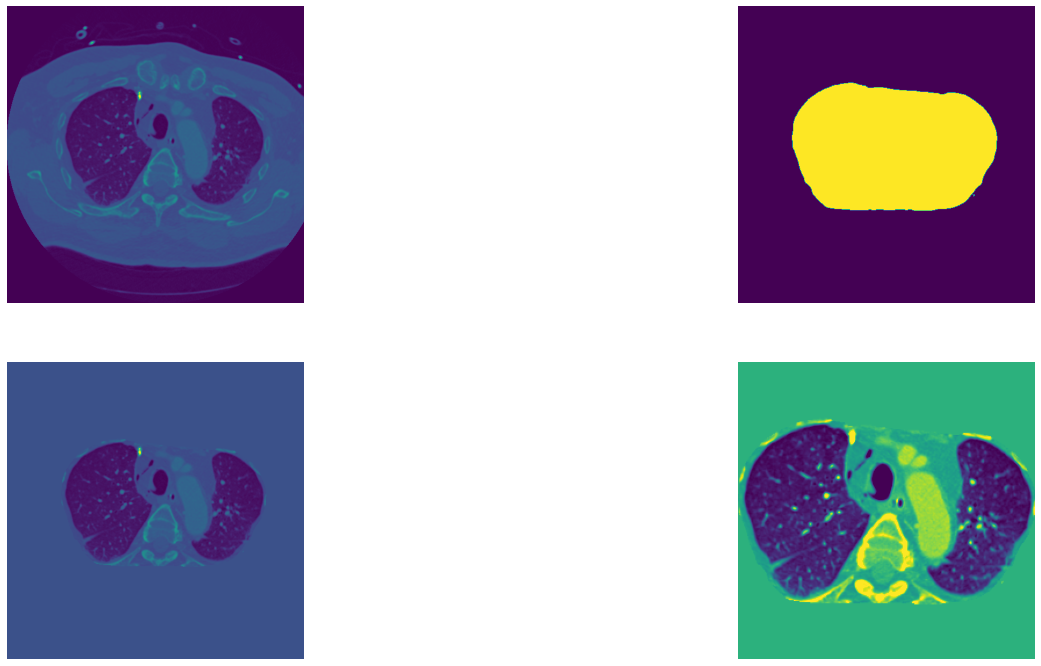

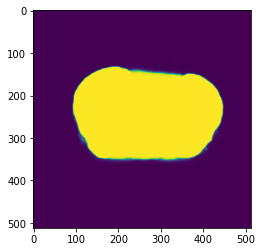

In [3061]:
# j=0
# j = 20
j = j+1
i = j%2
# if j%4 ==0:
x, y = test_generator.__getitem__(j)
y_pred = model.predict(x)[i]
fig, ax = plt.subplots(2, 2, figsize=[24, 12])
ax[0,0].imshow(x[i])
ax[0,0].axis('off')
y_pred_ = np.round(y_pred + 0.2) 
# y_pred_ = morphology.convex_hull_image(y_pred_)
ax[0,1].imshow(y_pred_)
ax[0,1].axis('off')
mask_img = x[i] * y_pred_
ax[1,0].imshow(mask_img)
ax[1,0].axis('off')

# y_pred = np.round(y_pred + 0.1)
x_min = np.min(tf.where(y_pred_ != 0)[:,0])
x_max = np.max(tf.where(y_pred_ != 0)[:,0])
y_min = np.min(tf.where(y_pred_ != 0)[:,1])
y_max = np.max(tf.where(y_pred_ != 0)[:,1])

x_mid = (x_min + x_max)/2
y_mid = (y_min + y_max)/2

x_dim = x_max - x_min
y_dim = y_max - y_min

print(x_max, x_min, y_min, y_max)

if x_dim < y_dim:
    mask_centered = resize(mask_img[int(x_mid-y_dim/2):int(x_mid+y_dim/2),y_min:y_max], (256,256,1),anti_aliasing = True).clip(-900,500)
else:
    mask_centered = resize(mask_img[x_min:x_max,int(y_mid-x_dim/2):int(y_mid+x_dim/2)], (256,256,1),anti_aliasing = True).clip(-900,500)

    

ax[1,1].imshow(mask_centered)
ax[1,1].axis('off')

plt.show()
plt.imshow(y_pred)

plt.show()

In [121]:
i, j

(2, 42)

In [98]:
np.round(y_pred + 0.1).sum()

19466.0

In [29]:
np.shape(origials[462])

(512, 512)

In [7]:
all_ids = pd.read_csv('all_ids_prcntcrd.csv')

In [117]:
first_scan = all_ids[(all_ids.negative_exam_for_pe == False) & (all_ids.StudyInstanceUID == '004f9a1605e7')].sort_values(by = 'percent_ycoord', ascending=False).reset_index(drop='True')

In [13]:
train_ids = pd.read_csv('train_df.csv')
val_ids = pd.read_csv('val_df.csv')
test_ids = pd.read_csv('test_df.csv')

all_ids[(all_ids.StudyInstanceUID.isin(train_ids.StudyInstanceUID)) | (all_ids.StudyInstanceUID.isin(val_ids.StudyInstanceUID)) | (all_ids.StudyInstanceUID.isin(test_ids.StudyInstanceUID))]

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate,ycoord,percent_ycoord
0,0038fd5f09f5,0f0fb8cd3ee9,0e0e3245f791,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-327.55,0.000000
1,0038fd5f09f5,0f0fb8cd3ee9,1ecd11276c6f,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-326.30,0.004367
2,0038fd5f09f5,0f0fb8cd3ee9,ce071b28dea6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-325.05,0.008734
3,0038fd5f09f5,0f0fb8cd3ee9,65785f3863c3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-323.80,0.013100
4,0038fd5f09f5,0f0fb8cd3ee9,2bccb0c22ef9,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-322.55,0.017467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937630,fb86440bd85f,46b29b8e73aa,a8d98f9303e8,0,0,0,0,0,1,0,1,0,0,1,1,1,0,66.25,0.979695
937631,fb86440bd85f,46b29b8e73aa,4e1bf3e4b5ac,0,0,0,0,0,1,0,1,0,0,1,1,1,0,67.50,0.984772
937632,fb86440bd85f,46b29b8e73aa,6d2442848d9a,0,0,0,0,0,1,0,1,0,0,1,1,1,0,68.75,0.989848
937633,fb86440bd85f,46b29b8e73aa,84ebfcc80186,0,0,0,0,0,1,0,1,0,0,1,1,1,0,70.00,0.994924
